In [8]:
#import all the package needed
#change the bias of loss to get a balanced ratio of accuracy
#use augmentation
#self.conv2_drop = nn.Dropout2d()

from __future__ import print_function
import torch
import numpy as np
import MNISTtools as mit
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from __future__ import print_function
import torch.utils.data as Data
import torchvision
import os
import matplotlib.pylab as plt
# import Augmentor

In [9]:
#define the architecture & all the function needed
#to be complete:
#1:the function to normalize images
#construct the architecture of the network
class Net(nn.Module):
    def __init__ (self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d (3,6,3)
        torch.nn.init.xavier_uniform(self.conv1.weight)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.conv1_drop = nn.Dropout()
        
        self.conv2 = nn.Conv2d (6,16,3)
        torch.nn.init.xavier_uniform(self.conv2.weight)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.conv2_drop = nn.Dropout2d()
        
        self.conv3 = nn.Conv2d(16,30,3)
        torch.nn.init.xavier_uniform(self.conv2.weight)
        self.conv3_bn = nn.BatchNorm2d(30)   
        self.conv3_drop = nn.Dropout2d()
        
        self.conv4 = nn.Conv2d(30,80,3)
        torch.nn.init.xavier_uniform(self.conv2.weight)
        self.conv4_bn = nn.BatchNorm2d(80)
        self.conv4_drop = nn.Dropout2d()
        
        self.conv5 = nn.Conv2d(80,100,3)
        torch.nn.init.xavier_uniform(self.conv2.weight)
        self.conv5_bn = nn.BatchNorm2d(100)
        
        #this is a parallel architecture.
        self.fc1 = nn.Linear(1200,1000)
        self.fc1_drop = nn.Dropout()
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.fc1_bn = nn.BatchNorm2d(1000)  
        self.fc2 = nn.Linear (1000,800)
        self.fc2_drop = nn.Dropout()
        torch.nn.init.xavier_uniform(self.fc2.weight)
        self.fc2_bn = nn.BatchNorm2d(800)    
        self.fc3 = nn.Linear (800,500)
        self.fc3_drop = nn.Dropout()
        torch.nn.init.xavier_uniform(self.fc3.weight)
        self.fc3_bn = nn.BatchNorm2d(500)       
        self.fc4 = nn.Linear (500,4)
        torch.nn.init.xavier_uniform(self.fc3.weight)
        
        self.fc5 = nn.Linear(1200,1000)
        self.fc5_drop = nn.Dropout()
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.fc5_bn = nn.BatchNorm2d(1000)       
        self.fc6 = nn.Linear (1000,800)
        self.fc6_drop = nn.Dropout()
        torch.nn.init.xavier_uniform(self.fc2.weight)
        self.fc6_bn = nn.BatchNorm2d(800)     
        self.fc7 = nn.Linear (800,500)
        self.fc7_drop = nn.Dropout()
        torch.nn.init.xavier_uniform(self.fc3.weight)
        self.fc7_bn = nn.BatchNorm2d(500)   
        self.fc8 = nn.Linear (500,4)
        torch.nn.init.xavier_uniform(self.fc3.weight)
        
    def forward(self,x):
        x = self.conv1_drop(F.max_pool2d(F.relu(self.conv1_bn(self.conv1(x))),(2,2)))
        x = self.conv2_drop(F.max_pool2d(F.relu(self.conv2_bn(self.conv2(x))),(2,2)))
        x = self.conv3_drop(F.max_pool2d(F.relu(self.conv3_bn(self.conv3(x))),(2,2)))
        x = self.conv4_drop(F.max_pool2d(F.relu(self.conv4_bn(self.conv4(x))),(2,2)))
        x = F.max_pool2d(F.relu(self.conv5_bn(self.conv5(x))),(2,2))
        x1 = x.view(-1,self.num_flat_features(x))
        
        x = self.fc1_drop(F.relu(self.fc1_bn(self.fc1(x1))))
        x = self.fc2_drop(F.relu(self.fc2_bn(self.fc2(x))))
        x = self.fc3_drop(F.relu(self.fc3_bn(self.fc3(x))))
        output_1 = self.fc4(x)
        
        y = self.fc5_drop(F.relu(self.fc5_bn(self.fc5(x1))))
        y = self.fc6_drop(F.relu(self.fc6_bn(self.fc6(y))))
        y = self.fc7_drop(F.relu(self.fc7_bn(self.fc7(y))))
        output_2 = self.fc8(y)
        
        return output_1,output_2
    
    def num_flat_features(self,x):
        size = x.size()[1:]
        return np.prod(size)

def label2onehot(lbl):                     
    d = np.zeros((lbl.max() + 1, lbl.size)) 
    d[lbl, np.arange(0, lbl.size)] = 1 
    return d

#this function is written for assignment#2,so to be modified
def normalize_MNIST_images(x):
    num_f = x.shape[0]
    x=x.astype(np.float64)
    mean_each_feature = np.mean(x,axis = 1).reshape(num_f,1)
    result = (x - mean_each_feature)/255
    return result,mean_each_feature

def accuracy(prediction,lable):
    assert len(prediction) == len(lable)
    return np.sum(prediction == lable).astype(float)/len(prediction)
    
def onehot2label(d):
    lbl = d.argmax(axis=0) 
    return lbl    

def Get_Desktop_Path():
    return os.path.join(os.path.expanduser("~"), 'Desktop')

def load_images(index_to_use):
    im = np.zeros((218,178,3,len(index_to_use)))
    for i in range(202599):
        if i in index_to_use:
            index = i
            i = '0'*(6-len(str(i+1)))+str(i+1)
            im[:,:,:,index_to_use.index(index)] = plt.imread('/datasets/ee285s-public/CelebA/Img/img_align_celeba/%s.jpg'%i)
    return im

#do the selection and preprocessing for labels,also could get which images(images' index) within dataset is qualified
def load_labels():
    # Bald             4
    # Black_Hair       8 
    # Blond_Hair       9      
    # Brown_Hair       11
    # Gray_Hair       17
    # Straight_Hair   32
    # Wavy_Hair       33
    # Wearing_Hat     35
    with open('/datasets/ee285s-public/CelebA/Anno/list_attr_celeba.txt','r')  as f:
        p_temp=f.readlines()
    p = []
    for i in p_temp:
        i = i[11:]
        i = i[:-2]
        i = i.replace(' ','')
        i = i.replace('-1','0')
        p.append(i)
    p = p[2:]   
    ylabel_temp = np.zeros((202599,40))
    index = 0
    for each in p:
        temp_x = []
        for i in each:
            temp_x.append(int(i))
        ylabel_temp[index,:] = np.array(temp_x)
        index += 1
    ylabel_for_color = ylabel_temp[:,[8,9,11,17]]
    ylabel_for_style = ylabel_temp[:,[4,32,33,35]]
    index_to_delete = image_to_abandon(ylabel_for_color,ylabel_for_style)
    index_to_use = np.delete(np.arange(202599),index_to_delete)
    return ylabel_for_color,ylabel_for_style,index_to_use.tolist()

def image_to_abandon(ylabel_for_color,ylabel_for_style):
    which_images_to_delete_1_1 = np.where(np.sum(ylabel_for_color,1) == 0)[0].tolist()
    which_images_to_delete_1_2 = np.where(np.sum(ylabel_for_style,1) == 0)[0].tolist()
    which_images_to_delete_2_1 = np.where(np.sum(ylabel_for_color,1) == 2)[0].tolist()
    which_images_to_delete_2_2 = np.where(np.sum(ylabel_for_color,1) == 3)[0].tolist()
    which_images_to_delete_2_3 = np.where(np.sum(ylabel_for_color,1) == 4)[0].tolist()
    which_images_to_delete_3_1 = np.where(np.sum(ylabel_for_style,1) == 2)[0].tolist()
    which_images_to_delete_3_2 = np.where(np.sum(ylabel_for_style,1) == 3)[0].tolist()
    which_images_to_delete_3_3 = np.where(np.sum(ylabel_for_style,1) == 4)[0].tolist()
    result = set(which_images_to_delete_1_1 + which_images_to_delete_1_2 + which_images_to_delete_2_1 + which_images_to_delete_2_2 + which_images_to_delete_2_3 + which_images_to_delete_3_1 + which_images_to_delete_3_2 + which_images_to_delete_3_3)
    return list(result)

#to randomly assign images' index into different batches per epoch
def get_the_step_indexassignment(train_family,batch):
    index_to_use = train_family
    np.random.shuffle(index_to_use)
    per_batch = family_of_index_to_use(index_to_use,batch)
    num_batch = len(per_batch)
    return per_batch,num_batch

#a subfunction within get_the_step_indexassignment,it's function is grouping the selected index
#into different batchs.
def family_of_index_to_use(index_to_use,batch = 1000):
    start = batch
    end = start + batch
    family_of_index_to_use = [index_to_use[0:batch]]
    while len(family_of_index_to_use[-1]) >= batch:
        family_of_index_to_use.append(index_to_use[start:end])
        start += batch
        end += batch
    family_of_index_to_use = family_of_index_to_use[:-1]
    return family_of_index_to_use
    
#use the assigned index to call the selected images from dataset.  
def get_x_for_thisbatch(perbatch_index,signal):
    if signal == False:
        x = load_images(perbatch_index)
        x = torch.from_numpy(np.moveaxis(np.moveaxis(x,-1,0),-1,1)).float()
    else:
        x = load_created_images(perbatch_index)
        x = torch.from_numpy(np.moveaxis(np.moveaxis(x,-1,0),-1,1)).float()
    return x

def load_created_images(perbatch_index):
    im = np.zeros((218,178,3,len(index_to_use)))
    for i in range(202599):
        if i in index_to_use:
            index = i
            i = '0'*(6-len(str(i+1)))+str(i+1)
            im[:,:,:,index_to_use.index(index)] = plt.imread('/datasets/ee285s-public/CelebA/Augmentation/%s.jpg'%i)
    return im

#call the labels    
def get_y_for_thisbatch(perbatch_index,ylabel):
    y = ylabel[perbatch_index,:].argmax(axis=1)
    y = torch.from_numpy(y).type(torch.LongTensor)  
    return y

def average(x):
    result = []
    for each in x:
        temp = each/2
        result.append(temp)
    return result

def do_some_statistics(prediction,label,chars):
    result = []
    for i in range(len(chars)):
        result.append(0)
    mis_pre = label[np.where((prediction != label) == 1)[0].tolist()]
    i = 0
    for each in chars:
        for pre in mis_pre:
            if pre == each:
                result[i] += 1
        i+=1
    return result
        
#this part of code is written to do the image augmentation locally
def augmentor():    
    p = Augmentor.Pipeline('/datasets/ee285s-public/CelebA/Img/img_align_celeba')
    p.random_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=8)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_left_right(probability=1)
    p.zoom(probability=0.5, min_factor=1.2, max_factor=1.3)
    p.gaussian_distortion(probability = 1,grid_width = 5,grid_height = 5,magnitude = 5,corner = 'bell',method = 'in')
    p.skew(probability = 0.5)
    p.process()
    p.sample(20)
    
def batch_rename_for_augmentor():
    i=0
    path='/Users/sdret/Desktop/image/img_align_celeba/output'
    filelist=os.listdir(path)
    for files in filelist:
        i=i+1
        Olddir=os.path.join(path,files)
        filename=os.path.splitext(files)[0]
        filetype=os.path.splitext(files)[1]
        Newdir=os.path.join('/Users/sdret/Desktop/image/img_align_celeba/output',files[26:32]+filetype);
        os.rename(Olddir,Newdir)

#this part of code is to get the path of target file on pod
# def processDirectory (args, dirname, filenames):
#     print 'Directory',dirname
#     for filename in filenames:
#         print ' File',filename


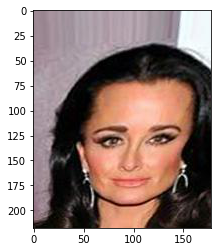

In [10]:
# os.path.walk(r'/datasets/ee285s-public/CelebA', processDirectory, None )
test_1 = plt.imread('/datasets/ee285s-public/CelebA/Img/img_align_celeba/202598.jpg')
test_2 = plt.imread('/datasets/ee285s-public/CelebA/Augmentation/202598.jpg')
plt.imshow(test_1)
plt.imshow(test_2)


In [11]:
#because the dataset we used are not initially suitable for our project,so we do some preprocessing &
#selection for it,all the first-step processing are included in the function load_labels()
#index_to_use is the index of image qualified for future use.
ylabel_for_color,ylabel_for_style,index_to_use = load_labels()
#for the randomness,we do the shuffling to the index
np.random.shuffle(index_to_use)
#because the limitaion of the cpu,we can not load all the images and into matrix form,instead
#when we need them,we load the data.

##separate the data into train & validation & test sets
##after the first selection,one must lock the this code,to keep the purity of test data.
# train_family = index_to_use[0:(72557/10)*6]
# validation_family = index_to_use[(72557/10)*6:(72557/10)*8]
# test_family = index_to_use[(72557/10)*8:]
# torch.save(train_family,'train_family.pkl')
# torch.save(validation_family,'validation_family.pkl')
# torch.save(test_family,'test_family.pkl')

#load all the data from previous training
train_family = torch.load('train_family.pkl')
validation_family = torch.load('validation_family.pkl')
test_family = torch.load('test_family.pkl')

In [12]:
#set all the hyperparameters(to be completed)
EPOCH = 100
LR = 0.001             
batch = 30   

net = Net()
net.cuda()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
# net.load_state_dict(torch.load('params.pkl'))

In [ ]:
# variation_loss = torch.load('variation_loss.pkl')
# variation_loss_val = torch.load('variation_loss_val.pkl')

#training section
#load some datas & net parameters from previous training
running_loss = 0.0
running_loss_2 = 0.0
# variation_loss = []
# variation_loss_val = []
# test_history_accuracy = []
# test_history_accuracy_col = []
# test_history_accuracy_sty = []
variation_loss = torch.load('variation_loss_1.pkl')
variation_loss_val = torch.load('variation_loss_val_1.pkl')
test_history_accuracy = torch.load('test_history_accuracy.pkl')
test_history_accuracy_col = torch.load('test_history_accuracy_col.pkl')
test_history_accuracy_sty = torch.load('test_history_accuracy_sty.pkl')
net.load_state_dict(torch.load('params.pkl'))
print('paremeters loaded')


for epoch in range(EPOCH):
    net.eval()
    signal = False
    perbatch_index,num_batch = get_the_step_indexassignment(train_family,batch)
    #get the epoch accuracy,due to the limitation of gpu memory,we could only use part of the test data to do the computation     
    index_accur = validation_family
    np.random.shuffle(index_accur)
    n = len(index_accur)/15
    x = Variable(get_x_for_thisbatch(index_accur[0:n],False)).cuda()
    y_col = get_y_for_thisbatch(index_accur[0:n],ylabel_for_color).numpy()
    y_sty = get_y_for_thisbatch(index_accur[0:n],ylabel_for_style).numpy()
    output_for_accuracy_col,output_for_accuracy_sty = net(x)
    prediction_col = onehot2label(output_for_accuracy_col.cpu().data.numpy().T)
    prediction_sty = onehot2label(output_for_accuracy_sty.cpu().data.numpy().T)
    accuracy_of_this_epoch_1 = accuracy(prediction_col,y_col)
    accuracy_of_this_epoch_2 = accuracy(prediction_sty,y_sty)
    test_history_accuracy_col.append(accuracy_of_this_epoch_1)
    test_history_accuracy_sty.append(accuracy_of_this_epoch_2)
    accuracy_of_this_epoch = accuracy_of_this_epoch_2 + accuracy_of_this_epoch_1
    print('accuracy of epoch for color',epoch+1,'=',accuracy_of_this_epoch_1)
    print('accuracy of epoch for style',epoch+1,'=',accuracy_of_this_epoch_2)
    torch.save(test_history_accuracy, 'test_history_accuracy.pkl')
    torch.save(test_history_accuracy_col,'test_history_accuracy_col.pkl')
    torch.save(test_history_accuracy_sty,'test_history_accuracy_sty.pkl')
    #early stopping to avoid overfitting
#     if epoch > 3:
#         if accuracy_of_this_epoch < (test_history_accuracy[-1]+test_history_accuracy[-2]+test_history_accuracy[-3])/3:
#             print('early stopped')
#             break;
    test_history_accuracy.append(accuracy_of_this_epoch)
    
    #train the model
    for step in range(num_batch*2):
        net.train()
        y_col = get_y_for_thisbatch(perbatch_index[step/2],ylabel_for_color)
        y_sty = get_y_for_thisbatch(perbatch_index[step/2],ylabel_for_style)
        x = 0
        x = get_x_for_thisbatch(perbatch_index[step/2],signal)
        b_y_col = Variable(y_col).cuda()
        b_y_sty = Variable(y_sty).cuda()
        b_x = Variable(x).cuda()
        output_col,output_sty = net(b_x)             
        loss = loss_func(output_col, b_y_col) + loss_func(output_sty, b_y_sty)
        
        optimizer.zero_grad()           
        loss.backward()                 
        optimizer.step()
        
        #get the variation of lost of validation set
        #to save source,just compute partial batch size of it
        arr = validation_family             
        np.random.shuffle(arr)
        arr = arr[0:batch/2]
        net.eval()
        yval_temp_col = get_y_for_thisbatch(arr,ylabel_for_color)
        yval_temp_sty = get_y_for_thisbatch(arr,ylabel_for_style)
        xval_temp = get_x_for_thisbatch(arr,False)
        b_y_col = Variable(yval_temp_col).cuda()
        b_y_sty = Variable(yval_temp_sty).cuda()
        b_x_2 = Variable(xval_temp).cuda()
        output_col,output_sty = net(b_x_2)             
        loss_2 = loss_func(output_col, b_y_col) + loss_func(output_sty, b_y_sty)
        
        running_loss += loss
        running_loss_2 += loss_2
        if step % 50 == 0:
            #to avoid recording some bad points.
            if running_loss.cpu().data[0] >= 5:
                variation_loss.append(running_loss.cpu().data.numpy())
            if running_loss_2.cpu().data[0] >= 5:
                variation_loss_val.append(running_loss_2.cpu().data.numpy())
                print(running_loss.cpu().data.numpy())                                      #loss per sample
            running_loss = 0.0
            running_loss_2 = 0.0
            torch.save(net.state_dict(), 'params.pkl')  
            torch.save(variation_loss, 'variation_loss_1.pkl')
            torch.save(variation_loss_val, 'variation_loss_val_1.pkl')
        #get some test prediction for comparsion 
        if step % 600 == 0:
            pre_select = test_family
            np.random.shuffle(pre_select)
            xtest = get_x_for_thisbatch(pre_select[:10],False)
            x = Variable(xtest).cuda()
            y_col = get_y_for_thisbatch(pre_select[:10],ylabel_for_color).numpy()
            y_sty = get_y_for_thisbatch(pre_select[:10],ylabel_for_style).numpy()
            output_for_accuracy_col,output_for_accuracy_sty = net(x)
            prediction_col = onehot2label(output_for_accuracy_col.cpu().data.numpy().T)
            prediction_sty = onehot2label(output_for_accuracy_sty.cpu().data.numpy().T)
            print('the original label for color is',y_col)
            print('and the prediction for color is',prediction_col)
            print('----------------------------------------------------')
            print('the original label for style is',y_sty)
            print('and the prediction for style is',prediction_sty)
    if signal == False:
        signal = True
    else:
        signal = False

paremeters loaded
accuracy of epoch for color 1 = 0.8407445708376422
accuracy of epoch for style 1 = 0.7125129265770423
the original label for color is [1 1 1 1 0 0 0 0 2 2]
and the prediction for color is [1 1 1 1 0 0 0 0 2 2]
----------------------------------------------------
the original label for style is [2 2 1 1 2 1 2 2 2 2]
and the prediction for style is [2 2 2 2 2 1 2 2 2 2]
[50.1486]
[49.766838]
[52.7629]
[54.221443]
[53.831524]
[51.950565]
[52.81624]
[48.58428]
[49.56095]
[49.403458]
[50.25477]
[53.246696]
the original label for color is [0 0 2 0 0 1 2 1 0 1]
and the prediction for color is [0 2 2 0 2 1 1 1 0 1]
----------------------------------------------------
the original label for style is [2 1 2 2 1 2 1 2 1 2]
and the prediction for style is [2 2 2 2 2 2 2 2 1 2]
[52.689655]
[50.481712]
[51.929626]
[53.003815]
[50.025833]
[51.927593]
[51.293655]
[49.638683]
[53.014805]
[49.753895]
[52.10572]
[50.30991]
the original label for color is [1 2 0 0 0 2 2 2 2 0]
and the pr

In [11]:
#analyze section
chars = [0,1,2,3]
result_for_col = np.zeros((1,4))
result_for_sty = np.zeros((1,4))
batch = 100
perbatch_index,num_batch = get_the_step_indexassignment(test_family,batch)
for step in range(num_batch):
    y_col = get_y_for_thisbatch(perbatch_index[step],ylabel_for_color)
    y_sty = get_y_for_thisbatch(perbatch_index[step],ylabel_for_style)
    x = get_x_for_thisbatch(perbatch_index[step],False)
    b_y_col = Variable(y_col).cuda()
    b_y_sty = Variable(y_sty).cuda()
    b_x = Variable(x).cuda()

    output_for_accuracy_col,output_for_accuracy_sty = net(b_x)
    prediction_col = onehot2label(output_for_accuracy_col.cpu().data.numpy().T)
    prediction_sty = onehot2label(output_for_accuracy_sty.cpu().data.numpy().T)    
    result_for_col += np.array(do_some_statistics(prediction_col,y_col.numpy(),chars))
    result_for_sty += np.array(do_some_statistics(prediction_sty,y_sty.numpy(),chars))


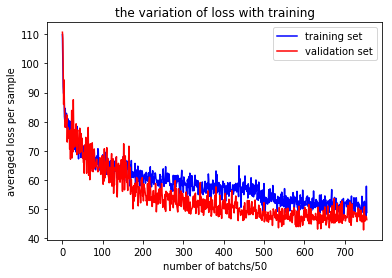

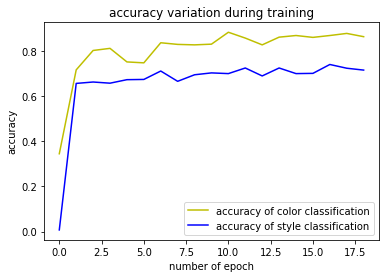

NameError: name 'result_for_col' is not defined

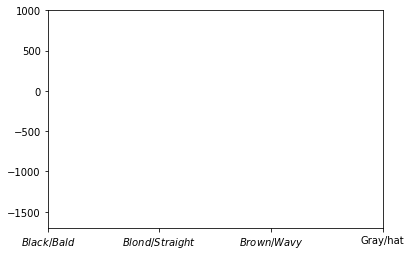

In [7]:
#plot section
plt.plot(range(len(variation_loss)),variation_loss,'b')
plt.plot(range(len(variation_loss_val)),variation_loss_val,'r')
plt.xlabel('number of batchs/50')
plt.ylabel('averaged loss per sample')
plt.title('the variation of loss with training')
plt.legend(['training set', 'validation set'])
plt.show()

plt.plot(range(len(test_history_accuracy_col)),test_history_accuracy_col,'y')
plt.xlabel('number of epoch')
plt.ylabel('accuracy')
plt.plot(range(len(test_history_accuracy_sty)),test_history_accuracy_sty,'b')
# plt.plot(range(len(test_history_accuracy)),average(test_history_accuracy),'r')
plt.title('accuracy variation during training')
plt.legend(['accuracy of color classification', 'accuracy of style classification','averaged accuracy of style & color classification'])
plt.show()

# x = np.linspace(-3, 3, 50)
# y = 2*x + 1
# x0 = 1
# y0 = 2*x0 + 1
# plt.figure(num=1, figsize=(8, 5),)
# plt.plot(x, y,)
# ax = plt.gca()
# ax.spines['right'].set_color('none')
# ax.spines['top'].set_color('none')
# ax.xaxis.set_ticks_position('bottom')
# ax.spines['bottom'].set_position(('data', 0))
# ax.yaxis.set_ticks_position('left')
# ax.spines['left'].set_position(('data', 0))
# plt.scatter(x0,y0)
# plt.plot([x0,x0],[y0,0],'k--')
# plt.annotate(r'$2x+1=%s$' % y0, xy=(x0, y0), xycoords='data', xytext=(+30, -30),
#              textcoords='offset points', fontsize=16,
#              arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2"))
# plt.text(-3.7, 3, r'$This\ is\ the\ some\ text. \mu\ \sigma_i\ \alpha_t$',
#          fontdict={'size': 16, 'color': 'r'})

x_temp = np.array([0,1,2,3])
plt.xticks(x_temp,[r'$Black/Bald$',r'$Blond/Straight$',r'$Brown/Wavy$','Gray/hat'])
X = np.array([0,1,2,3])
plt.ylim(-1700, 1000)
plt.bar(X, +result_for_col.T.reshape(4,), facecolor='#9999ff', edgecolor='white')
plt.bar(X, -result_for_sty.T.reshape(4,), facecolor='#ff9999', edgecolor='white')
for x, y in zip(X, result_for_col.T.reshape(4,)):
    plt.text(x, y + 0.02, '%.2f' % y, ha='center', va='bottom')
for x, y in zip(X, -result_for_sty.T.reshape(4,)):
    plt.text(x, y - 0.05, '%.2f' % y, ha='center', va='top')
    plt.title('number of misclassifications of each class in test sets')
plt.show()